In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import array_to_latex, plot_histogram
import numpy as np
from qiskit_aer import AerSimulator
from wt_functions import *
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [2]:
# create random 4x4 patch input
np.random.seed(0)
X = np.random.rand(4, 4).astype(float)

# create the bits
q = QuantumRegister(4, "q")
c = ClassicalRegister(4, "c")

# create statevector
psi = X.flatten()
norm = np.linalg.norm(psi)
amps = psi / norm

# create wavelet transform circuit
qc = QuantumCircuit(q, c)
qc.initialize(amps, q)
qc.swap(q[0],q[1])
qc.h(q[1])
qc.x(q[1])
qc.ch(q[1],q[0])
qc.x(q[1])
qc.swap(q[2],q[3])
qc.h(q[3])
qc.x(q[3])
qc.ch(q[3],q[2])
qc.x(q[3])
qc.measure(q,c)

In [ ]:
# connect to runtime service
service = QiskitRuntimeService(channel="ibm_quantum_platform")
backend = service.least_busy(simulator=False, operational=True)

# compiler
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
tqc = pm.run(qc)

# run the circuit
shots = 20000
sampler = SamplerV2(mode=backend)
job = sampler.run([tqc], shots=shots)
result = job.result()

# obtain probability distribution output from quantum hardware
pub_result = result[0]
reg_name = list(pub_result.data.keys())[0]
print(f"Register: {reg_name}")

counts = pub_result.data[reg_name].get_counts()
prob_distribution = {k: v / shots for k, v in counts.items()}

# fill in 0 probabilty bit strings
n = qc.num_qubits
full_distribution = {format(i, f"0{n}b"): prob_distribution.get(format(i, f"0{n}b"), 0.0) for i in range(2**n)}

# find output elements
amp_magnitudes = {b: np.sqrt(p) for b, p in full_distribution.items()}

# print quantum and classical outputs
q_output = np.array(list(amp_magnitudes.values())).reshape(4, 4)
print("Quantum Output:\n", q_output)

Yc = haar_transform_2d_classical(X) / norm
print("\nClassical Output:\n", Yc)

qiskit_runtime_service.__init__:WARNING:2026-02-15 18:55:23,598: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-02-15 18:55:24,137: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2026-02-15 18:55:25,705: Using instance: open-instance, plan: open


Register: c
Quantum Output:
 [[0.85032347 0.17578396 0.07245688 0.06442049]
 [0.20012496 0.15016657 0.117047   0.10099505]
 [0.13802174 0.07245688 0.05196152 0.10977249]
 [0.20964255 0.17306068 0.18384776 0.05830952]]

Classical Output:
 [[ 0.91442991  0.12204016 -0.02350484 -0.02118513]
 [ 0.0491792  -0.15077581 -0.08658321 -0.09108147]
 [ 0.00180456  0.05328093  0.01119008  0.10257259]
 [ 0.14389606 -0.18540747  0.18784657  0.05587149]]


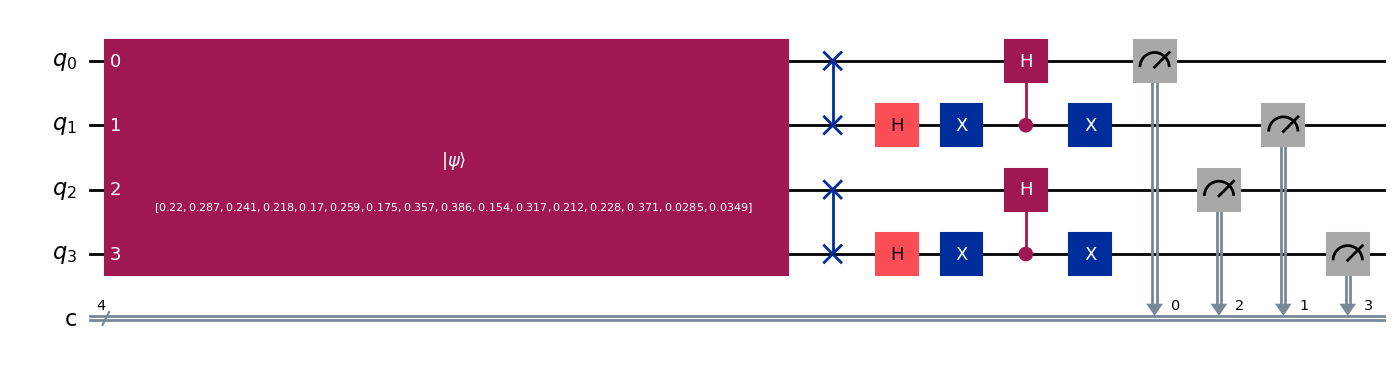

In [ ]:
# sv_ideal = Statevector.from_instruction(qc).data
# Yq_ideal = sv_ideal.reshape(4, 4)
# print("Quantum Output:\n", Yq_ideal.real)

# qc_op = Operator.from_circuit(qc)
# latex_circuit = array_to_latex(
#     qc_op.data,
#     max_size=qc_op.data.shape,
#     precision=3
# )
# display(latex_circuit)

display(qc.draw(output="mpl"))